# Lesson 2 : LangGraph Components

In [ ]:
# 1. Update package list
!apt-get update -q

# 2. Install the required system dependencies
!apt-get install -y graphviz graphviz-dev pkg-config

# 3. Now install pygraphviz (this should work now)
#!pip install pygraphviz

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,747 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [4,532 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64

In [ ]:
!pip install IPython langchain_core langchain_openai langchain_community pygraphviz
#!pip install langgraph langchain_core langchain_openai langchain_community pygraphviz
print("done")

  Using cached pygraphviz-1.14.tar.gz (106 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached jedi-0.19.2-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.2-py2.py3-none-any.whl (1.6 MB)
  Created wheel for pygraphviz: filename=pygraphviz-1.14-cp311-cp311-linux_x86_64.whl size=169719 sha256=8a2dc58489662b9faaca7683f057a7c8a51512b223e30ac5a720ba4d0041ff53
  Stored in directory: /root/.cache/pip/wheels/9c/5f/df/6fffd2a4353f26dbb0e3672a1baf070c124a1d74a5f9318279
Successfully built pygraphviz
done


In [ ]:
import os
from google.colab import userdata

# Get the API keys from Colab secrets
openai_api_key = userdata.get('OPENAI_API_KEY')
tavily_api_key = userdata.get('TAVILY_API_KEY')

# Set them as environment variables
os.environ['OPENAI_API_KEY'] = openai_api_key
os.environ['TAVILY_API_KEY'] = tavily_api_key

# Verify they're set (optional)
print("API keys set successfully!")
print(f"OpenAI key first 10 characters: {os.environ['OPENAI_API_KEY'][:10]}...")
print(f"Tavily key first 10 characters: {os.environ['TAVILY_API_KEY'][:10]}...")

API keys set successfully!
OpenAI key first 10 characters: sk-proj-Iw...
Tavily key first 10 characters: tvly-dev-8...


In [ ]:
#from dotenv import load_dotenv
#_ = load_dotenv()

In [ ]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [ ]:
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


/tmp/ipython-input-9-144666821.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tool = TavilySearchResults(max_results=4) #increased number of results


> If you are not familiar with python typing annotation, you can refer to the [python documents](https://docs.python.org/3/library/typing.html).

In [ ]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

> Note: in `take_action` below, some logic was added to cover the case that the LLM returned a non-existent tool name. Even with function calling, LLMs can still occasionally hallucinate. Note that all that is done is instructing the LLM to try again! An advantage of an agentic organization.

In [ ]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [ ]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
abot = Agent(model, [tool], system=prompt)

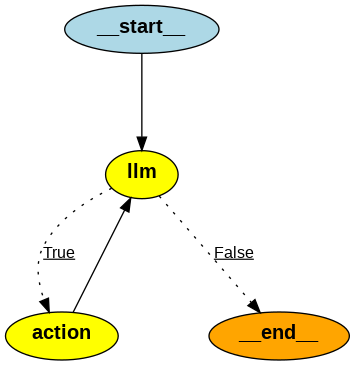

In [ ]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [ ]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_QpBged3t32RNxRCX3KbXtvJK', 'type': 'tool_call'}
Back to the model!


In [ ]:
result

{'messages': [HumanMessage(content='What is the weather in sf?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_QpBged3t32RNxRCX3KbXtvJK', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BlYod6zRJXim16yawSwnv0UfZswLy', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b1509c63-d549-4f19-a9ac-0a3d50b1192e-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, '

In [ ]:
result['messages'][-1].content

'The weather forecast for San Francisco on June 23, 2025, indicates sunny weather with a daytime temperature ranging from 63°F to 70°F and a nighttime temperature of 52°F to 54°F.'

In [ ]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_GQADcOb6qBm9rk5qfDJbJLiw', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_V7U8teD2mCsoVthorIgXtJkZ', 'type': 'tool_call'}
Back to the model!


In [ ]:
result['messages'][-1].content

'The weather in San Francisco is currently around 63-66°F during the day and 52-54°F at night. It is sunny with some clouds. The UV index is high, so precautions against sun exposure are advised.\n\nIn Los Angeles, the temperature is around 79°F during the day and 59°F at night. It is also sunny with a low chance of precipitation. The UV index is 11, indicating very high exposure levels.\n\nIf you need more detailed information or have any specific preferences, feel free to ask!'

In [ ]:
# Note, the query was modified to produce more consistent results.
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question."
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Super Bowl 2024 winner'}, 'id': 'call_kaGqQph1srB4TfX79pYbcOvW', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Kansas City Chiefs headquarters state'}, 'id': 'call_hZVjqPkgaWAv1izQQy8BCyb9', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Missouri GDP 2024'}, 'id': 'call_SMp1csP019jsCoMcXE2anUts', 'type': 'tool_call'}
Back to the model!


In [ ]:
print(result['messages'][-1].content)

1. The Kansas City Chiefs won the Super Bowl in 2024, defeating the San Francisco 49ers 25-22 in overtime.

2. The Kansas City Chiefs are headquartered in Kansas City, Missouri.

3. By late 2024, Missouri's GDP reached approximately $455 billion, making it the 22nd-largest economy in the United States.
